# Modelagem de Machine Learning - Dados Tabulares

Este notebook implementa modelos de classificação para prever o diagnóstico médico com base em variáveis clínicas.

## Objetivos

1. Preparar os dados para modelagem
2. Treinar e avaliar modelos de classificação:
   - Regressão Logística
   - Random Forest
3. Comparar o desempenho dos modelos
4. Analisar a importância das features
5. Salvar o melhor modelo para uso futuro

## Metodologia

- **Divisão dos dados**: 80% treino / 20% teste (estratificada)
- **Pré-processamento**: Normalização com StandardScaler
- **Métricas de avaliação**: Precision, Recall, F1-Score, Accuracy


In [ ]:
# ============================================================================
# IMPORTAÇÕES
# ============================================================================

# Bibliotecas para manipulação de dados e visualização
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import joblib
import os
import sys
from pathlib import Path

# Configuração do path para importar módulos do projeto
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Scikit-learn: modelos e métricas
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Módulos customizados do projeto
from src.tabular.processing import split_data, build_pipeline

# Carregamento da configuração
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Carregamento dos dados
df = pd.read_csv(f"../{config['data']['tabular_path']}")
print(f"Dataset carregado: {df.shape[0]} amostras, {df.shape[1]} features")


## 1. Preparação dos Dados

Nesta etapa, preparamos os dados para o treinamento:
- Separação entre features (X) e variável alvo (y)
- Remoção de colunas não relevantes
- Tratamento de valores ausentes e infinitos
- Divisão em conjuntos de treino e teste (estratificada)


In [ ]:
# Separação entre features (variáveis preditoras) e variável alvo
X = df.drop(["diagnosis", "id", "Unnamed: 32"], axis=1, errors="ignore")
y = df["diagnosis"]

print(f"Features: {X.shape[1]} variáveis")
print(f"Variável alvo: {y.name}")
print(f"Classes: {y.unique()}")

# Tratamento de valores ausentes e infinitos
# Substitui infinitos por NaN e depois preenche com a média da coluna
X = X.replace([np.inf, -np.inf], np.nan)
if X.isna().sum().sum() > 0:
    print(f"\nValores NaN encontrados: {X.isna().sum().sum()}")
    X = X.fillna(X.mean())
    print("Valores NaN preenchidos com a média da coluna")
else:
    print("\nNenhum valor NaN encontrado")

# Divisão estratificada dos dados (mantém proporção das classes)
# test_size: proporção do conjunto de teste (padrão: 20%)
# random_state: garante reprodutibilidade
X_train, X_test, y_train, y_test = split_data(
    X, y,
    test_size=config["split"]["test_size"],
    random_state=config["split"]["random_state"]
)

print(f"\nDivisão dos dados:")
print(f"  Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Teste:  {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribuição das classes no treino:")
print(y_train.value_counts())
print(f"\nDistribuição das classes no teste:")
print(y_test.value_counts())


## 2. Modelo 1: Regressão Logística

A Regressão Logística é um modelo linear que estima probabilidades usando uma função logística. É interpretável e funciona bem como baseline.

**Parâmetros:**
- `solver='lbfgs'`: Algoritmo de otimização robusto
- `C=1.0`: Parâmetro de regularização (inverso da força de regularização)
- `max_iter`: Número máximo de iterações (definido no config.yaml)


In [ ]:
# Suprimir warnings numéricos durante o treinamento
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Criação do modelo de Regressão Logística
lr = LogisticRegression(
    max_iter=config["models"]["logistic_regression"]["max_iter"],
    solver='lbfgs',  # Algoritmo de otimização robusto para problemas pequenos/médios
    C=1.0,  # Parâmetro de regularização (inverso da força)
    random_state=42  # Garante reprodutibilidade
)

# Construção do pipeline: StandardScaler + Modelo
# O StandardScaler normaliza as features (média=0, desvio=1)
lr_pipeline = build_pipeline(lr)

# Treinamento do modelo
print("Treinando Regressão Logística...")
lr_pipeline.fit(X_train, y_train)

# Predições no conjunto de teste
y_pred_lr = lr_pipeline.predict(X_test)

# Avaliação do modelo
print("\n" + "="*60)
print("REGRESSÃO LOGÍSTICA - Relatório de Classificação")
print("="*60)
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           B       0.96      0.99      0.97        72
           M       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



## 3. Modelo 2: Random Forest

Random Forest é um algoritmo de ensemble que combina múltiplas árvores de decisão. É mais robusto a overfitting e geralmente apresenta melhor desempenho.

**Parâmetros:**
- `n_estimators`: Número de árvores no ensemble (definido no config.yaml)
- `max_depth`: Profundidade máxima das árvores (definido no config.yaml)
- `random_state`: Garante reprodutibilidade


In [ ]:
# Criação do modelo Random Forest
rf = RandomForestClassifier(
    n_estimators=config["models"]["random_forest"]["n_estimators"],  # Número de árvores
    max_depth=config["models"]["random_forest"]["max_depth"],  # Profundidade máxima
    random_state=42  # Garante reprodutibilidade
)

# Construção do pipeline: StandardScaler + Modelo
rf_pipeline = build_pipeline(rf)

# Treinamento do modelo
print("Treinando Random Forest...")
rf_pipeline.fit(X_train, y_train)

# Predições no conjunto de teste
y_pred_rf = rf_pipeline.predict(X_test)

# Avaliação do modelo
print("\n" + "="*60)
print("RANDOM FOREST - Relatório de Classificação")
print("="*60)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



## 4. Análise de Resultados

### 4.1 Matriz de Confusão

A matriz de confusão mostra a distribuição das predições versus os valores reais, permitindo identificar:
- **Verdadeiros Positivos (TP)**: Casos corretamente classificados como positivos
- **Verdadeiros Negativos (TN)**: Casos corretamente classificados como negativos
- **Falsos Positivos (FP)**: Casos negativos classificados como positivos
- **Falsos Negativos (FN)**: Casos positivos classificados como negativos


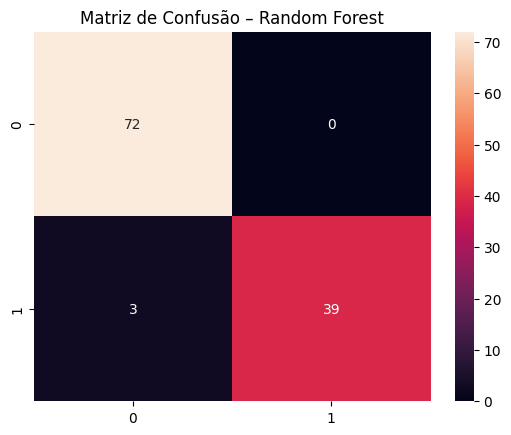

In [ ]:
# Criação da matriz de confusão para o modelo Random Forest
cm = confusion_matrix(y_test, y_pred_rf)

# Visualização da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,  # Mostra os valores nas células
    fmt="d",  # Formato inteiro
    cmap="Blues",  # Esquema de cores
    xticklabels=['B', 'M'],  # Labels das classes
    yticklabels=['B', 'M'],
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de Confusão – Random Forest", fontsize=14, fontweight='bold', pad=15)
plt.ylabel("Valor Real", fontsize=12)
plt.xlabel("Valor Predito", fontsize=12)
plt.tight_layout()
plt.show()

# Análise detalhada da matriz
print("\nAnálise da Matriz de Confusão:")
print(f"  Verdadeiros Negativos (TN): {cm[0,0]}")
print(f"  Falsos Positivos (FP):      {cm[0,1]}")
print(f"  Falsos Negativos (FN):      {cm[1,0]}")
print(f"  Verdadeiros Positivos (TP): {cm[1,1]}")


### 4.2 Importância das Features

A importância das features no Random Forest indica quais variáveis são mais relevantes para as predições. Isso ajuda a:
- Entender quais características clínicas são mais importantes
- Identificar features redundantes
- Melhorar a interpretabilidade do modelo


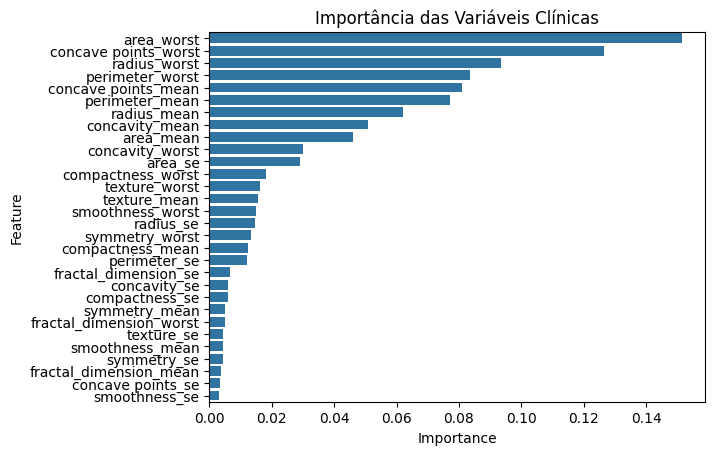

In [ ]:
# Extração do modelo do pipeline para acessar feature_importances_
rf_model = rf_pipeline.named_steps['model']
importances = rf_model.feature_importances_
features = X.columns

# Criação de DataFrame com importâncias ordenadas
fi = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Visualização das top 15 features mais importantes
top_n = 15
fi_top = fi.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=fi_top, palette="viridis")
plt.title(f"Top {top_n} Variáveis Mais Importantes - Random Forest", 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Importância", fontsize=12)
plt.ylabel("Variável", fontsize=12)
plt.tight_layout()
plt.show()

# Exibição das top 10 features
print(f"\nTop 10 Features Mais Importantes:")
print("="*50)
for idx, row in fi.head(10).iterrows():
    print(f"{row['Feature']:30s}: {row['Importance']:.4f}")


## 5. Persistência do Modelo

Salvamos o melhor modelo (Random Forest) para uso futuro em produção ou inferência.


In [ ]:
# Criação do diretório de modelos (se não existir)
os.makedirs("../models", exist_ok=True)

# Salvamento do pipeline completo (inclui StandardScaler + Random Forest)
# O pipeline garante que novos dados sejam pré-processados da mesma forma
model_path = "../models/maternal_risk_model.pkl"
joblib.dump(rf_pipeline, model_path)

print(f"✓ Modelo salvo com sucesso em: {model_path}")
print(f"  Tamanho do arquivo: {os.path.getsize(model_path) / 1024:.2f} KB")


Modelo salvo em: ../models/maternal_risk_model.pkl


## 6. Validação do Modelo Salvo

Testamos o carregamento do modelo salvo para garantir que está funcionando corretamente.


In [ ]:
# Importação da função para carregar o modelo
from src.tabular.evaluate import load_model

# Carregamento do modelo salvo
print("Carregando modelo salvo...")
loaded_model = load_model("../models/maternal_risk_model.pkl")

# Teste de predição com algumas amostras do conjunto de teste
test_samples = X_test.head(5)
predictions = loaded_model.predict(test_samples)
actual = y_test.head(5).values

print("\nTeste de Predição:")
print("="*50)
for i, (pred, actual_val) in enumerate(zip(predictions, actual)):
    status = "✓" if pred == actual_val else "✗"
    print(f"Amostra {i+1}: Predito={pred}, Real={actual_val} {status}")

print(f"\n✓ Modelo carregado e funcionando corretamente!")


array(['B', 'M', 'B', 'M', 'B'], dtype=object)